<a href="https://colab.research.google.com/github/zardemostoles/zardemostoles-uoc.edu/blob/master/TFG_Modelo_Diagnostico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Carga de módulos que se emplean en el notebook

In [1]:
# Se instala EfficientNet
!pip install -q efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 2.8 MB/s eta 0:00:00


In [2]:
# Se importan los módulos que se van a utilizar en el notebook

# Módulos básicos
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Módulo para mostrar imágenes
import PIL

# Módulo para realizar la particiones de datos
from sklearn.model_selection import train_test_split

# Módulos de TensorFLow y Keras
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.models import load_model

# Módulo de EfficientNet
import efficientnet.tfkeras as efn

# Variables comunes del proyecto
# Se monta el Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Variables
import sys
sys.path.append('/content/drive/MyDrive/TFG/')
from TFG_Comun import *

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Se comprueba la versión de TensorFlow
print(tf.__version__)
print(tf.keras.__version__)

# Preprocesamiento y entrenamiento de TensorFlow (prefetch) automático
AUTO = tf.data.AUTOTUNE

2.9.2
2.9.0


## Definición de funciones



### Funciones de tratamiento de TFRecords y Datasets

In [4]:
# Función para convertir una imagen en un tensor, creando un tensor con las 
# dimensiones requeridas y normalizado.
# image: representación RGB de la imagen 
# size: dimensiones del tensor a los que se redimensiona (variable global)
def prepare_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    # Dimensiona a las dimensiones del tensor
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

# Función para extraer de un TFRecord la imagen, el nombre de la imagen y 
# el diagnóstico.
def read_labeled_tfrecord_with_file_name(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), 
        "image_name": tf.io.FixedLenFeature([], tf.string),  
        "patient_id": tf.io.FixedLenFeature([], tf.int64),
        "sex": tf.io.FixedLenFeature([], tf.int64),
        "age_approx": tf.io.FixedLenFeature([], tf.int64),
        "anatom_site_general_challenge": tf.io.FixedLenFeature([], tf.int64),
        "diagnosis": tf.io.FixedLenFeature([], tf.int64),
        "target": tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = prepare_image(example['image'])
    image_name = example['image_name']
    target = tf.cast(example['target'], tf.int32)
    return image, image_name, target


# Función para filtrar los registros cuyo nombre de imágen no termine con
# '_downsample'
def filter_images(image, image_name, target):
  return not tf.strings.regex_full_match(image_name,"^((.*_downsampled))")

# Función para filtrar los registros con diagnóstico de melanoma
def filter_images_melanoma(image, image_name, target):
  return target == 1

# Función para filtrar los registros con diagnóstico de no melanoma
def filter_images_no_melanoma(image, image_name, target):
  return target == 0

# Función para suprimir el nombre del fichero de los registros
def remove_file_name(image, file, target):
  return image, target

# Función para cargar en un dataset los TFRecords de un conjunto de registros
def load_dataset(filenames):
    # Lecturas en paralelo
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    # Construye el dataset con el formato definido,
    # descartando los que sean 'downsample'
    dataset = dataset.map(read_labeled_tfrecord_with_file_name, 
                          num_parallel_calls=AUTO).filter(filter_images)
    # Devuekve un dataset con )image, image_name, target)
    return dataset


# Función para extraer un dataset de otro dataset dados los índices
# (se utiliza para particionar un dataset)
def get_selected_dataset(ds, X_indices_np):
    # Crea un tensor del tipo tf.int64 como el de Dataset.enumerate(). 
    X_indices_ts = tf.constant(X_indices_np, dtype=tf.int64)
    
    # Función que devuelve True si el índice esta incluido en X_indices_ts
    def is_index_in(index, rest):
        return tf.math.reduce_any(index == X_indices_ts)
    
    def drop_index(index, rest):
        return rest

    # Dataset.enumerate() is similter to Python's enumerate().
    # Se filtran los indices que se han pasado como parámetro y se devuelve el
    # dataset con dichos índices
    selected_ds = ds \
        .enumerate() \
        .filter(is_index_in) \
        .map(drop_index)
    return selected_ds

# Función que realiza 'data augmentation' sobre una imagen
def data_augment(image, target):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image  = tf.image.random_hue(image, 0.01)
    image = tf.image.random_saturation(image, 0.7, 1.3)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.image.random_brightness(image, 0.1)
    return image, target

# Función que devuelve el dataset de entrenamiento
def get_training_dataset(ds, do_augment=False):
    dataset = ds
    dataset = ds.map(remove_file_name)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    if do_augment:  dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.prefetch(AUTO) 
    return dataset

# Función que devuelve el dataset de validación
def get_validation_dataset(ds):
    dataset = ds
    dataset = ds.map(remove_file_name)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # 
    return dataset

# Función que devuelve el dataset de prueba
def get_test_dataset(ds):
    dataset = ds
    #dataset = ds.map(remove_file_name)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # 
    return dataset

### Funciones para el entrenamiento del modelo


In [101]:
# Función que devuelve una fila para añadir a un dataframe con las métricas
def create_metric_row(model_name, lr, bias, dropout, model_history):
  # Crea una nueva fila con las estadísticas del último epoch del entrenamento
  val_auc_roc = round(model_history['val_auc_roc'] [-1],3)
  val_auc_pr = round(model_history['val_auc_pr'] [-1],3)
  val_precision = round(model_history['val_precision'] [-1],3)
  val_recall = round(model_history['val_recall'] [-1], 3)
  val_F1 = round(2*val_precision*val_recall / (val_precision+val_recall),3)

  new_row = {'nombre_modelo': model_name,
             'lr': lr,
             'bias': bias,
             'dropout': dropout,
             'val_auc_roc': val_auc_roc,
             'val_auc_pr': val_auc_pr,
             'val_precision': val_precision,
             'val_recall': val_recall,
             'val_F1': val_F1
             }
  return new_row

# Función de checkpoint para guardar el mejor modelo según una métrica 
# durante el entrenamiento
def make_model_check_point(best_model_file_path, metric='val_auc_pr'):
    return ModelCheckpoint(
        best_model_file_path, monitor=metric, mode='max',
        verbose=1, save_best_only=True, save_weights_only=False, period=1)

# Funcióm para crear un modelo EfficientNet
def create_model(lr=0.00005, init_bias=False, 
                 dropout=0.2, dense_bias_initializer=0, effnet_version=4):
  BATCH_SIZE = 16 * strategy.num_replicas_in_sync
  #resolution = "384x384"
  #IMAGE_SIZE = RESOLUTIONS[resolution]
  
  eff_function = {
      0: efn.EfficientNetB0,
      1: efn.EfficientNetB1,
      2: efn.EfficientNetB2,
      3: efn.EfficientNetB3,
      4: efn.EfficientNetB4,
      5: efn.EfficientNetB5,
      6: efn.EfficientNetB6,
      7: efn.EfficientNetB7
  }

  K.clear_session()

  optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

  with strategy.scope():

      # Capas de EfficientNet
      eff_function = eff_function[effnet_version]
      effnet_layer = eff_function(
                include_top=False, weights="noisy-student",  #'noisy-student', #imagenet
                input_shape=(*IMAGE_SIZE, 3), pooling='avg')
      # Capa Dense (totalmente conectada)
      if init_bias:
        dense_layer = Dense(1, bias_initializer=dense_bias_initializer,
                      activation='sigmoid',name='classify')
      else:
        dense_layer = Dense(1, activation='sigmoid',name='classify')

      # Se crea el modelo
      if (dropout > 0):
        model = Sequential([
                effnet_layer,
                Dropout(dropout, name="dropout"),
                dense_layer])
      else:
        model = Sequential([
                effnet_layer,
                dense_layer])
      
      # Métricas que se van a medir
      metrics = [ AUC(name='auc_roc', curve='ROC'), 
                 AUC(name='auc_pr', curve='PR'),
                 Precision(name='precision'), Recall(name='recall') ]  
  
  # Compila el modelo
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=metrics)
  model.summary()
  return model

# Función para mostrar una curva de rendimiento del entrenamiento
def display_training_curve(training, validation, title, subplot, ylim):
  # Se definen los subplots en la primera llamada
  if subplot%10==1: 
      plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
      plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title(title)
  ax.set_ylabel(title)
  ax.set_ylim(*ylim)
  ax.set_xlabel('Época')
  ax.legend(['Entreno', 'Valid.'])

# Función para mostrar las curvas de rendimiento del entrenamiento de modelo    
def display_curves(history):
  display_training_curve(
      history.history['auc_roc'], history.history['val_auc_roc'],
      'AUC ROC', 221, (0.5, 1.0))
  display_training_curve(
      history.history['auc_pr'], history.history['val_auc_pr'],
      'AUC PR', 222, (0.5, 1.0))
  display_training_curve(
      history.history['precision'], history.history['val_precision'],
      'Precisión', 223, (0.0, 1.0))
  display_training_curve(
      history.history['recall'], history.history['val_recall'],
      'Sensibilidad', 224, (0.0, 1.0))   

### Funciones de visualización de imágenes

In [6]:
# Dots per Inch para mostrar imágenes en un monitor de resolución 1366x768
MY_DPI = 96

# Función que muestra en pantalla las imágenes contenidas en un dataset con
# su correspondiente diagnóstico (etiqueta)
def show_sample_images(thumb_size, ds):
  for img, file, target in iter(ds):
    plt.figure(figsize=(thumb_size/MY_DPI, thumb_size/MY_DPI), dpi=MY_DPI)
    file_name = file.numpy().decode('ascii')
    target_diag = "Melanoma" if target.numpy() else "No melanoma"
    image = img.numpy().astype(np.uint8)
    image = PIL.Image.fromarray(image)
    print("File: {} Size: {} Diagnóstico: {}".format(file_name, image.size,target_diag))
    plt.imshow(image)
    plt.show()
    print("\n")

# Función para mostrar un mosaico con imágenes
def show_mosaic_images(thumb_size, cols, rows, ds):
    mosaic = PIL.Image.new(mode='RGB', size=(thumb_size*cols + (cols-1), thumb_size*rows + (rows-1)))
    for idx, data in enumerate(iter(ds)):
        img, target = data[0], data[1]
        ix  = idx % cols
        iy  = idx // cols
        img = img.numpy().astype(np.uint8)
        img = PIL.Image.fromarray(img)
        img = img.resize((thumb_size, thumb_size), resample=PIL.Image.BILINEAR)
        mosaic.paste(img, (ix*thumb_size + ix, 
                           iy*thumb_size + iy))
        if idx > cols*rows: break
    display(mosaic)

### Funciones auxiliares

In [7]:
# Función para imprimir el total de casos de cada categoría y el el porcentaje de 
# la categoría positiva respecto al total
def print_target_counts(y, label):
    _, y_counts = np.unique(y, return_counts=True)
    y_total = len(y)
    y_0_count = y_counts[0]
    y_1_count = y_counts[1]
    y_1_percent = y_1_count / y_total * 100.0
    print("{0:10s}: Total={1:5d}, 0={2:5d}, 1={3:3d}, porcentaje de melanoma={4:.2f}%".format(
        label, y_total, y_0_count, y_1_count, y_1_percent))

## Configuración del entorno hardware

In [81]:
# Detecta hardware, devuelve la estrategia de distribución apropiada el HW.
try:
    # TPU detectada 
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('TPU disponible ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    # default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()
    print("GPUs disponibles: ", len(tf.config.list_physical_devices('GPU')))

print("Réplicas:", strategy.num_replicas_in_sync)

# Configura el tamaño del batch
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
print("Tamaño de batch:", BATCH_SIZE)

TPU disponible  grpc://10.33.2.202:8470


Réplicas: 8
Tamaño de batch: 128


## Carga de los ficheros de TFRecords en datasets

In [9]:
# Resoluciones que se van a utilizar para el entrenamiento del modelo
RESOLUTIONS = {
  "256x256": [256, 256],
  "384x384": [384, 384],
  "512x512": [512, 512],
  "768x768": [768, 768]
}

# Resolución de las imágenes del modelo
MODEL_RESOLUTION = "384x384"
IMAGE_SIZE = RESOLUTIONS[MODEL_RESOLUTION]

# Carga los TFRecords 
dataset_files = {}
for resolution, path in GCS_PATHS.items():
    print("Resolution: {}, path: {}".format(resolution, path))
    dataset_files[resolution] = tf.io.gfile.glob(path + '/train*.tfrec')
    print("TFRecord files: ({})".format(len(dataset_files[resolution])))

Resolution: 256x256, path: gs://kds-3239769f3bf431af9c56f000077238d8a4f7cd01649e3338338272a7
TFRecord files: (30)
Resolution: 384x384, path: gs://kds-596d0b7e5fe874664cfd3f9d754d9d00ac8f1db5a4840e8205339f7a
TFRecord files: (30)
Resolution: 512x512, path: gs://kds-8609a7229b66fb75206dc951d5c291bc342d0a15fe515e14b8ca0b52
TFRecord files: (30)
Resolution: 768x768, path: gs://kds-80bcf7222f4fb9464cef1839e1a7db42f9e9f470f5d809c6e773fd9d
TFRecord files: (30)


In [10]:
# Carga de los conjuntos de datos desde los ficheros TFRecord
full_datasets = {}
for resolution, files in dataset_files.items():
  IMAGE_SIZE = RESOLUTIONS[resolution]
  full_datasets[resolution] = load_dataset(files)
  print(resolution, full_datasets[resolution])

256x256 <FilterDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>
384x384 <FilterDataset element_spec=(TensorSpec(shape=(384, 384, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>
512x512 <FilterDataset element_spec=(TensorSpec(shape=(512, 512, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>
768x768 <FilterDataset element_spec=(TensorSpec(shape=(768, 768, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>


## Visualización de ejemplos de imágenes

File: ISIC_0000002 Size: (384, 384) Diagnóstico: Melanoma


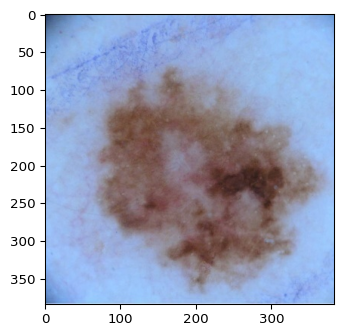



File: ISIC_0053467 Size: (384, 384) Diagnóstico: No melanoma


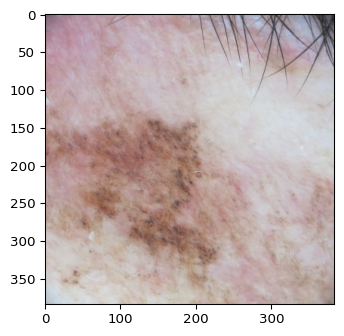

Exception ignored in: <function Executor.__del__ at 0x7f82b87f5160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


In [11]:
# Muestra 2 ejemplos de imágenes
examples = full_datasets[MODEL_RESOLUTION].take(2)
show_sample_images(RESOLUTIONS[MODEL_RESOLUTION][0], examples)



### Visualización de ejemplos de imágenes con diagnóstico de melanoma

Exception ignored in: <function Executor.__del__ at 0x7f82b87f5160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


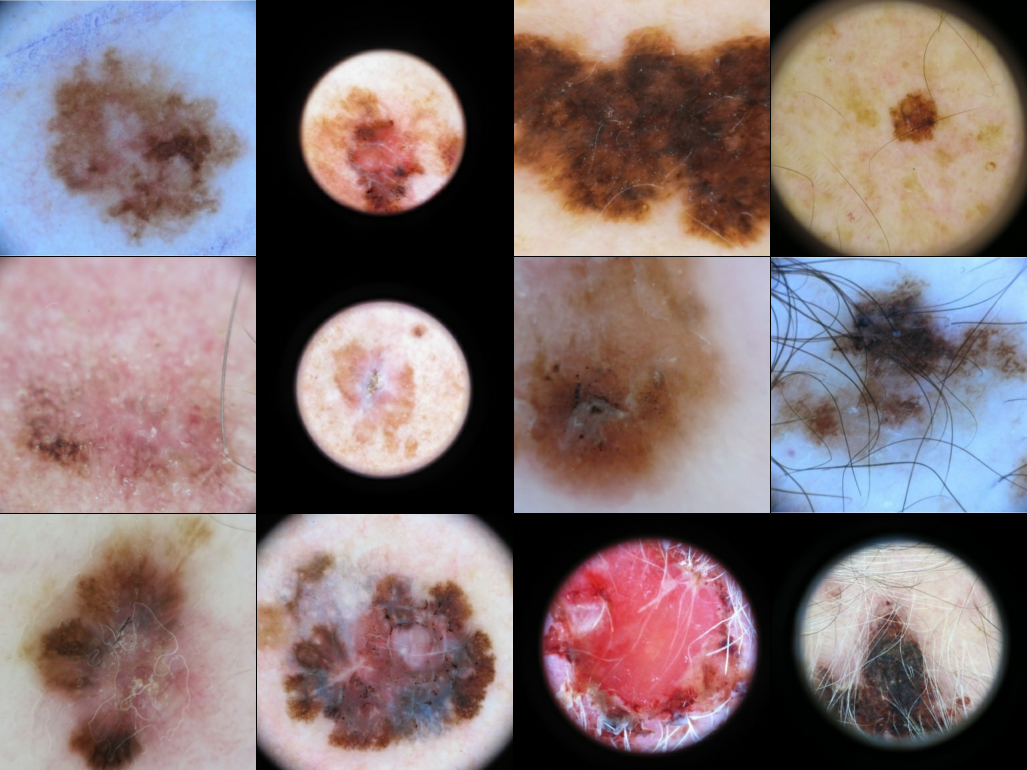

In [12]:
ds = full_datasets[MODEL_RESOLUTION].filter(filter_images_melanoma).take(4*3) 
show_mosaic_images(256, 4, 3, ds)

### Visualización de ejemplos de imágenes con diagnóstico de no melanoma

Exception ignored in: <function Executor.__del__ at 0x7f82b87f5160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


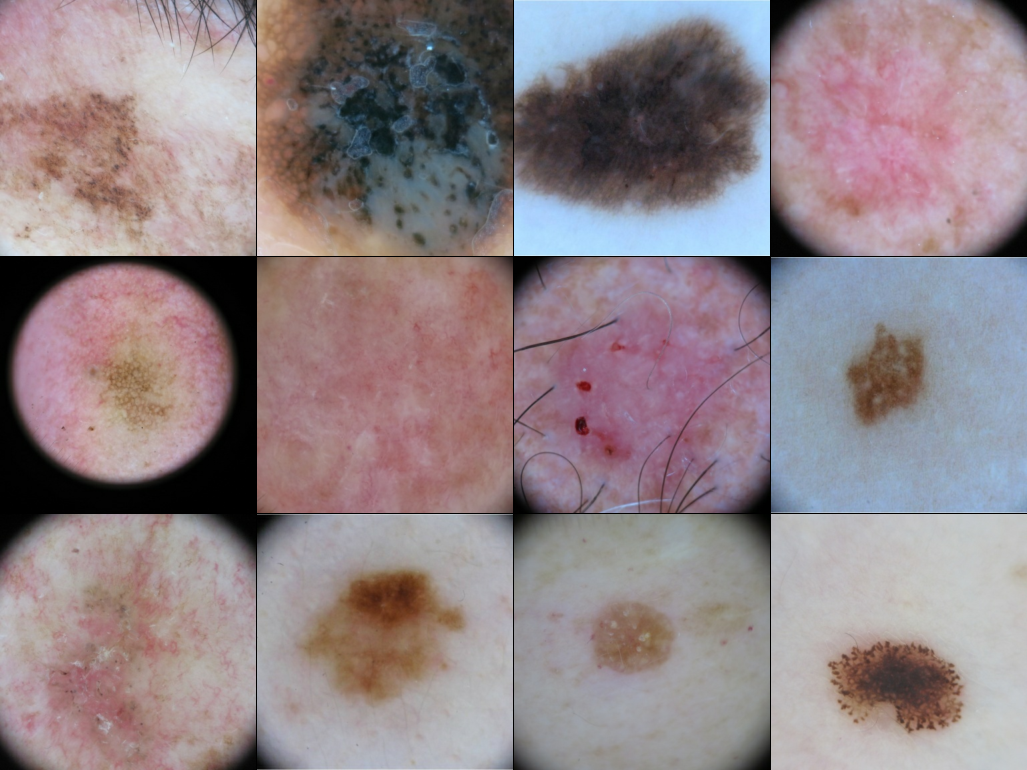

In [13]:
ds = full_datasets[MODEL_RESOLUTION].filter(filter_images_no_melanoma).take(4*3)
show_mosaic_images(256, 4, 3, ds)

## Preparación del conjunto de datos para experimentos y para prueba

El conjunto de datos de prueba se separa y solamente se usa con el modelo ya entrenado para evaluar el rendimiento y la equidad del modelo.

In [14]:
# Extrae los valores de los diagnósticos (etiqueta) para el conjunto de datos completo.
# Se generan los indices que son utilizados para filtrar el dataset.
y_targets = np.array([target.numpy() for img, file, target in iter(full_datasets[MODEL_RESOLUTION])])
X_indices = np.arange(len(y_targets))

print_target_counts(y_targets, "Total")

Exception ignored in: <function Executor.__del__ at 0x7f82b87f5160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Total     : Total=23218, 0=19076, 1=4142, porcentaje de melanoma=17.84%


In [15]:
# Particiona el conjunto de datos completo en datos para experimentos 
# y para pruebas
X_exp_indices, X_test_indices, y_exp_targets, y_test_targets = train_test_split(
    X_indices, y_targets, test_size=0.15, stratify=y_targets, random_state=53)

# Muestra la distrubución de los diagnósticos en el conjunto de 
# experimentos y de pruebas
print_target_counts(y_exp_targets, "Entrenamiento:")
print_target_counts(y_test_targets, "Prueba:")

Entrenamiento:: Total=19735, 0=16214, 1=3521, porcentaje de melanoma=17.84%
Prueba:   : Total= 3483, 0= 2862, 1=621, porcentaje de melanoma=17.83%


In [16]:
# Crea los datasets para entrenamiento (experiment_datasets) 
# y para pruebas (test_datasets)
experiment_datasets = {}
test_datasets = {} 
for resolution, full_dataset in full_datasets.items():
  experiment_datasets[resolution] =  get_selected_dataset(full_dataset, X_exp_indices)
  test_datasets[resolution] =  get_selected_dataset(full_dataset, X_test_indices)

print(experiment_datasets)
print(test_datasets)

{'256x256': <MapDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>, '384x384': <MapDataset element_spec=(TensorSpec(shape=(384, 384, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>, '512x512': <MapDataset element_spec=(TensorSpec(shape=(512, 512, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>, '768x768': <MapDataset element_spec=(TensorSpec(shape=(768, 768, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>}
{'256x256': <MapDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>, '384x384

In [17]:
# Muestra la distrubución de los diagnósticos en el conjunto de entrenamiento
y_targets = np.array([ target.numpy() for img, file, 
                      target in iter(experiment_datasets[MODEL_RESOLUTION])])
print_target_counts(y_targets, "Total")

Exception ignored in: <function Executor.__del__ at 0x7f82b87f5160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Total     : Total=19735, 0=16214, 1=3521, porcentaje de melanoma=17.84%


In [18]:
# Muestra la distribución de los diagnósticos en el conjunto de pruebas
y_targets = np.array([ target.numpy() for img, file, target in iter(test_datasets[MODEL_RESOLUTION])])
print_target_counts(y_targets, "Total")

Exception ignored in: <function Executor.__del__ at 0x7f82b87f5160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Total     : Total= 3483, 0= 2862, 1=621, porcentaje de melanoma=17.83%


## Preparación de el conjunto de datos para entrenamiento y para validación

El conjunto de datos de experimientos se particiona en conjunto de datos de entrenamiento y de validación. El conjunto de datos de validación se emplea para ajustar los parámetros del modelo y son vistos por el modelo durante el entrenamiento.

In [19]:
# Se divide el conjunto de datos de experimentos en conjunto de datos 
# de entrenamimiento y conjunto de datos de validación

# Extrae los valores de los diagnósticos (etiqueta) para el conjunto de datos de experimentos
# Se generan los indices que son utilizados para filtrar el dataset.
y_targets = np.array([ target.numpy() for img, file, 
                      target in iter(experiment_datasets[MODEL_RESOLUTION])])
X_indices = np.arange(len(y_targets))

X_train_indices, X_val_indices, y_train_targets, y_val_targets = train_test_split(
    X_indices, y_targets, test_size=0.15, stratify=y_targets, random_state=53)

# Número de imágenes que se van a usar para entrenamiento y para validación
NUM_TRAINING_IMAGES = len(y_train_targets)
NUM_VALIDATION_IMAGES = len(y_val_targets)

print_target_counts(y_train_targets, "Entrenamiento")
print_target_counts(y_val_targets, "Validación")

Exception ignored in: <function Executor.__del__ at 0x7f82b87f5160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Entrenamiento: Total=16774, 0=13781, 1=2993, porcentaje de melanoma=17.84%
Validación: Total= 2961, 0= 2433, 1=528, porcentaje de melanoma=17.83%


In [20]:
# Crea los datasets para entrenamiento y validación
training_datasets = {}
validation_datasets = {} 
for resolution, experiment_dataset in experiment_datasets.items():
  training_datasets[resolution] =  get_selected_dataset(experiment_dataset, X_train_indices)
  validation_datasets[resolution] =  get_selected_dataset(experiment_dataset, X_val_indices)

print(training_datasets)
print(validation_datasets)

{'256x256': <MapDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>, '384x384': <MapDataset element_spec=(TensorSpec(shape=(384, 384, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>, '512x512': <MapDataset element_spec=(TensorSpec(shape=(512, 512, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>, '768x768': <MapDataset element_spec=(TensorSpec(shape=(768, 768, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>}
{'256x256': <MapDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>, '384x384

## Preparación para el entrenamiento del modelo

In [21]:
# Cálculo de los pasos por época
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE  * 1

# Cálculo del bías inicial
_, (y_target_neg_count, y_target_pos_count) = np.unique(y_targets, return_counts=True)
y_target_pos_ratio = y_target_pos_count / y_target_neg_count
dence_initial_bias = math.log(y_target_pos_ratio)
dense_bias_initializer = Constant(dence_initial_bias)

print("No melanoma:" , y_target_neg_count, "Melanoma; ", y_target_pos_count)
print("Ratio:", y_target_pos_ratio)
print("Bias inicial:", dence_initial_bias)

No melanoma: 16214 Melanoma;  3521
Ratio: 0.21715801159491796
Bias inicial: -1.5271300263926


## Creación de experimentos

In [22]:
# Se crea un dataframe para almacenar los resultados de los experimentos
df_metrics = pd.DataFrame(columns=['nombre_modelo', 
                                   'lr', 
                                   'bias',
                                   'dropout',
                                   'val_auc_roc',
                                   'val_auc_pr',
                                   'val_precision',
                                   'val_recall',
                                   'val_F1'])

### Experimentos con learning rate
- EfficientNet-B0
- Resolución 256x256
- Sin sesgo inicial
- Sin dropout
- Learning rate: [0.00500, 0.00100, 0.00050, 0.00010, 0.00005]


In [23]:
# Resolución de las imágenes del modelo
MODEL_RESOLUTION = "256x256"
IMAGE_SIZE = RESOLUTIONS[MODEL_RESOLUTION]
learning_rate =  [0.00500, 0.00100, 0.00050, 0.00010, 0.00005]


In [24]:
# Semilla aleatoria para reproductibilidad
tf.keras.utils.set_random_seed(32)

# Crea y entrena los modelos
for lr in learning_rate:
  print("**************************")
  print("Experimento con lr=", lr)
  print("**************************")
  model = create_model(lr=lr, 
                     init_bias=False, 
                     dropout=0, 
                     effnet_version=0)
  # Se entrena el modelo
  history = model.fit(
    get_training_dataset(training_datasets[MODEL_RESOLUTION]), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=15, validation_data=get_validation_dataset(validation_datasets[MODEL_RESOLUTION]),
    verbose=1)
  
  # Se almacenan los resultados 
  new_row = create_metric_row('B0', lr=lr, bias=0, dropout=0, 
                              model_history=history.history)
  print(new_row)
  df_metrics = df_metrics.append(new_row, ignore_index=True)

**************************
Experimento con lr= 0.005
**************************
16696600/16696600 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functional  (None, 1280)             4049564   
 )                                                               
                                                                 
 classify (Dense)            (None, 1)                 1281      
                                                                 
Total params: 4,050,845
Trainable params: 4,008,829
Non-trainable params: 42,016
_________________________________________________________________
Epoch 1/15
131/131 [==============================] - 109s 434ms/step - loss: 0.3931 - auc_roc: 0.7842 - auc_pr: 0.4588 - precision: 0.5803 - recall: 0.2697 - val_loss: 1.8609 - val_auc_roc: 0.5654 - val_auc_pr: 0.2364 - val_p

In [25]:
# Métricas de los experimentos
df_metrics

nombre_modelo       lr bias dropout  val_auc_roc  val_auc_pr  val_precision  \
0            B0  0.00500    0       0        0.830       0.582          0.413   
1            B0  0.00100    0       0        0.892       0.751          0.728   
2            B0  0.00050    0       0        0.912       0.794          0.707   
3            B0  0.00010    0       0        0.921       0.809          0.767   
4            B0  0.00005    0       0        0.916       0.802          0.778   

   val_recall  val_F1  
0       0.716   0.524  
1       0.708   0.718  
2       0.718   0.712  
3       0.693   0.728  
4       0.652   0.709

### Experimentos con sesgo inicial
- EfficientNetB0
- Resolución 256x256
- Con sesgo inicial
- Sin dropout
- Learning rate: [0.00050, 0.00010, 0.00005]

In [26]:
# Semilla aleatoria para reproductibilidad
tf.keras.utils.set_random_seed(32)

learning_rate = [0.00050, 0.00010, 0.00005]
# Crea y entrena los modelos
for lr in learning_rate:
  print("**************************")
  print("Experimento con lr=", lr)
  print("**************************")
  model = create_model(lr=lr, 
                     init_bias=True, 
                     dense_bias_initializer=dense_bias_initializer,
                     dropout=0, 
                     effnet_version=0)
  # Se entrena el modelo
  history = model.fit(
    get_training_dataset(training_datasets[MODEL_RESOLUTION]), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=15, validation_data=get_validation_dataset(validation_datasets[MODEL_RESOLUTION]),
    verbose=1)
  
  # Se almacenan los resultados 
  new_row = create_metric_row('B0', lr=lr, bias=1, dropout=0, 
                              model_history=history.history)
  print(new_row)
  df_metrics = df_metrics.append(new_row, ignore_index=True)


**************************
Experimento con lr= 0.0005
**************************
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functional  (None, 1280)             4049564   
 )                                                               
                                                                 
 classify (Dense)            (None, 1)                 1281      
                                                                 
Total params: 4,050,845
Trainable params: 4,008,829
Non-trainable params: 42,016
_________________________________________________________________
Epoch 1/15
131/131 [==============================] - 111s 443ms/step - loss: 0.3414 - auc_roc: 0.8412 - auc_pr: 0.6070 - precision: 0.7068 - recall: 0.3717 - val_loss: 0.4614 - val_auc_roc: 0.7800 - val_auc_pr: 0.4998 - val_precision: 0.4396 - val_recall: 0.4754
Epoch 2/15
131/131 [======

In [27]:
df_metrics

nombre_modelo       lr bias dropout  val_auc_roc  val_auc_pr  val_precision  \
0            B0  0.00500    0       0        0.830       0.582          0.413   
1            B0  0.00100    0       0        0.892       0.751          0.728   
2            B0  0.00050    0       0        0.912       0.794          0.707   
3            B0  0.00010    0       0        0.921       0.809          0.767   
4            B0  0.00005    0       0        0.916       0.802          0.778   
5            B0  0.00050    1       0        0.908       0.796          0.795   
6            B0  0.00010    1       0        0.921       0.797          0.742   
7            B0  0.00005    1       0        0.930       0.809          0.710   

   val_recall  val_F1  
0       0.716   0.524  
1       0.708   0.718  
2       0.718   0.712  
3       0.693   0.728  
4       0.652   0.709  
5       0.718   0.755  
6       0.742   0.742  
7       0.731   0.720

### Experimentos con dropout
- EfficientNet-B0
- Resolución 256x256
- Con sesgo inicial
- Dropout: [0.2, 0.3, 0.4, 0.5]
- Learning rate: 0.00005

In [28]:
# Semilla aleatoria para reproductibilidad
tf.keras.utils.set_random_seed(32)

learning_rate = [0.00050, 0.00010, 0.00005]
# Crea y entrena los modelos
lr = 0.00005
dropout = [0.2, 0.3, 0.4, 0.5]

for d_out in dropout:
  print("**************************")
  print("Experimento con dropout=", d_out)
  print("**************************")
  model = create_model(lr=lr, 
                     init_bias=True, 
                     dense_bias_initializer=dense_bias_initializer,
                     dropout=d_out, 
                     effnet_version=0)
  # Se entrena el modelo
  history = model.fit(
    get_training_dataset(training_datasets[MODEL_RESOLUTION]), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=15, validation_data=get_validation_dataset(validation_datasets[MODEL_RESOLUTION]),
    verbose=1)
  
  # Se almacenan los resultados 
  new_row = create_metric_row('B0', lr, bias=1, dropout=d_out, model_history=history.history)
  print(new_row)
  df_metrics = df_metrics.append(new_row, ignore_index=True)

**************************
Experimento con dropout= 0.2
**************************
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functional  (None, 1280)             4049564   
 )                                                               
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 classify (Dense)            (None, 1)                 1281      
                                                                 
Total params: 4,050,845
Trainable params: 4,008,829
Non-trainable params: 42,016
_________________________________________________________________
Epoch 1/15
131/131 [==============================] - 112s 446ms/step - loss: 0.4002 - auc_roc: 0.7676 - auc_pr: 0.4725 - precision: 0.7310 - recall: 0.1463

In [29]:
# Métricas de los experimentos
df_metrics

nombre_modelo       lr bias dropout  val_auc_roc  val_auc_pr  \
0             B0  0.00500    0       0        0.830       0.582   
1             B0  0.00100    0       0        0.892       0.751   
2             B0  0.00050    0       0        0.912       0.794   
3             B0  0.00010    0       0        0.921       0.809   
4             B0  0.00005    0       0        0.916       0.802   
5             B0  0.00050    1       0        0.908       0.796   
6             B0  0.00010    1       0        0.921       0.797   
7             B0  0.00005    1       0        0.930       0.809   
8             B0  0.00005    1     0.2        0.924       0.805   
9             B0  0.00005    1     0.3        0.924       0.796   
10            B0  0.00005    1     0.4        0.934       0.813   
11            B0  0.00005    1     0.5        0.930       0.821   

    val_precision  val_recall  val_F1  
0           0.413       0.716   0.524  
1           0.728       0.708   0.718  
2           0.707       0.718   0.712  
3           0.767       0.693   0.728  
4           0.778       0.652   0.709  
5           0.795       0.718   0.755  
6           0.742       0.742   0.742  
7           0.710       0.731   0.720  
8           0.820       0.636   0.716  
9           0.767       0.659   0.709  
10          0.682       0.754   0.716  
11          0.837       0.631   0.720

### Experimentos con EfficientNet-B1 y EfficientNet-B2
- EfficientNet-B1 y EfficientNet-B2
- Resolución 256x256
- Con sesgo inicial
- Dropout: 0.4
- Learning rate: 0.00005

In [30]:
# Resolución de las imágenes del modelo
MODEL_RESOLUTION = "256x256"
IMAGE_SIZE = RESOLUTIONS[MODEL_RESOLUTION]
# dropout
d_out = 0.4

# Crea y entrena los modelos
for eff_version in [1,2]:
  print("********************************")
  print("Experimento con EfficientNet =", eff_version)
  print("*********************************")
  model = create_model(lr=0.00005, 
                     init_bias=True, 
                     dense_bias_initializer=dense_bias_initializer,
                     dropout=d_out, 
                     effnet_version=eff_version)
  # Se entrena el modelo
  history = model.fit(
    get_training_dataset(training_datasets[MODEL_RESOLUTION]), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=15, validation_data=get_validation_dataset(validation_datasets[MODEL_RESOLUTION]),
    verbose=1)
  
  # Se almacenan los resultados 
  new_row = create_metric_row("B" + str(eff_version), lr, bias=1, dropout=d_out, model_history=history.history)
  print(new_row)
  df_metrics = df_metrics.append(new_row, ignore_index=True)

********************************
Experimento con EfficientNet = 1
*********************************
27010080/27010080 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b1 (Functional  (None, 1280)             6575232   
 )                                                               
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 classify (Dense)            (None, 1)                 1281      
                                                                 
Total params: 6,576,513
Trainable params: 6,514,465
Non-trainable params: 62,048
_________________________________________________________________
Epoch 1/15
131/131 [==============================] - 146s 509ms/step - lo

In [31]:
# Métricas de los experimentos
df_metrics

nombre_modelo       lr bias dropout  val_auc_roc  val_auc_pr  \
0             B0  0.00500    0       0        0.830       0.582   
1             B0  0.00100    0       0        0.892       0.751   
2             B0  0.00050    0       0        0.912       0.794   
3             B0  0.00010    0       0        0.921       0.809   
4             B0  0.00005    0       0        0.916       0.802   
5             B0  0.00050    1       0        0.908       0.796   
6             B0  0.00010    1       0        0.921       0.797   
7             B0  0.00005    1       0        0.930       0.809   
8             B0  0.00005    1     0.2        0.924       0.805   
9             B0  0.00005    1     0.3        0.924       0.796   
10            B0  0.00005    1     0.4        0.934       0.813   
11            B0  0.00005    1     0.5        0.930       0.821   
12            B1  0.00005    1     0.4        0.939       0.815   
13            B2  0.00005    1     0.4        0.926       0.814   

    val_precision  val_recall  val_F1  
0           0.413       0.716   0.524  
1           0.728       0.708   0.718  
2           0.707       0.718   0.712  
3           0.767       0.693   0.728  
4           0.778       0.652   0.709  
5           0.795       0.718   0.755  
6           0.742       0.742   0.742  
7           0.710       0.731   0.720  
8           0.820       0.636   0.716  
9           0.767       0.659   0.709  
10          0.682       0.754   0.716  
11          0.837       0.631   0.720  
12          0.760       0.744   0.752  
13          0.753       0.735   0.744

### Experimentos con EfficientNet-B3 y EfficientNet-B4
- EfficientNet-B3 y EfficientNet-B4
- Resolución 384x384
- Con sesgo inicial
- Dropout: 0.4
- Learning rate: 0.00005

In [32]:
# Resolución de las imágenes del modelo
MODEL_RESOLUTION = "384x384"
IMAGE_SIZE = RESOLUTIONS[MODEL_RESOLUTION]

# dropout
d_out = 0.4

# Crea y entrena los modelos
for eff_version in [3,4]:
  print("********************************")
  print("Experimento con EfficientNet =", eff_version)
  print("*********************************")
  model = create_model(lr=0.00005, 
                     init_bias=True, 
                     dense_bias_initializer=dense_bias_initializer,
                     dropout=d_out, 
                     effnet_version=eff_version)
  # Se entrena el modelo
  history = model.fit(
    get_training_dataset(training_datasets[MODEL_RESOLUTION]), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=15, validation_data=get_validation_dataset(validation_datasets[MODEL_RESOLUTION]),
    verbose=1)
  
  # Se almacenan los resultados 
  new_row = create_metric_row("B" + str(eff_version), lr, bias=1, dropout=d_out, model_history=history.history)
  print(new_row)
  df_metrics = df_metrics.append(new_row, ignore_index=True)

********************************
Experimento con EfficientNet = 3
*********************************
43933088/43933088 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b3 (Functional  (None, 1536)             10783528  
 )                                                               
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 classify (Dense)            (None, 1)                 1537      
                                                                 
Total params: 10,785,065
Trainable params: 10,697,769
Non-trainable params: 87,296
_________________________________________________________________
Epoch 1/15
131/131 [==============================] - 182s 699ms/step - 

In [33]:
# Métricas de los experimentos
df_metrics

nombre_modelo       lr bias dropout  val_auc_roc  val_auc_pr  \
0             B0  0.00500    0       0        0.830       0.582   
1             B0  0.00100    0       0        0.892       0.751   
2             B0  0.00050    0       0        0.912       0.794   
3             B0  0.00010    0       0        0.921       0.809   
4             B0  0.00005    0       0        0.916       0.802   
5             B0  0.00050    1       0        0.908       0.796   
6             B0  0.00010    1       0        0.921       0.797   
7             B0  0.00005    1       0        0.930       0.809   
8             B0  0.00005    1     0.2        0.924       0.805   
9             B0  0.00005    1     0.3        0.924       0.796   
10            B0  0.00005    1     0.4        0.934       0.813   
11            B0  0.00005    1     0.5        0.930       0.821   
12            B1  0.00005    1     0.4        0.939       0.815   
13            B2  0.00005    1     0.4        0.926       0.814   
14            B3  0.00005    1     0.4        0.941       0.838   
15            B4  0.00005    1     0.4        0.945       0.853   

    val_precision  val_recall  val_F1  
0           0.413       0.716   0.524  
1           0.728       0.708   0.718  
2           0.707       0.718   0.712  
3           0.767       0.693   0.728  
4           0.778       0.652   0.709  
5           0.795       0.718   0.755  
6           0.742       0.742   0.742  
7           0.710       0.731   0.720  
8           0.820       0.636   0.716  
9           0.767       0.659   0.709  
10          0.682       0.754   0.716  
11          0.837       0.631   0.720  
12          0.760       0.744   0.752  
13          0.753       0.735   0.744  
14          0.721       0.824   0.769  
15          0.797       0.788   0.792

In [38]:
# Guarda el dataframe de métricas
df_metrics.to_csv("df_metrics.csv")

### Experimentos con EfficientNet-B5, EfficientNet-B6 y EfficientNet-B7
- EfficientNet-B5, EfficientNet-B6 y EfficientNet-B7 
- Resolución 512x512
- Con sesgo inicial
- Dropout: 0.4
- Learning rate: 0.00005

#### EfficientNet-B5

In [51]:
# Resolución de las imágenes del modelo
MODEL_RESOLUTION = "512x512"
IMAGE_SIZE = RESOLUTIONS[MODEL_RESOLUTION]
# Cálculo de los pasos por época
STEPS_PER_EPOCH = round(NUM_TRAINING_IMAGES // BATCH_SIZE * 1.1)
# dropout
d_out = 0.4

# Crea y entrena los modelos
for eff_version in [6]:
  print("********************************")
  print("Experimento con EfficientNet =", eff_version)
  print("*********************************")
  model = create_model(lr=0.00005, 
                       init_bias=True, 
                       dense_bias_initializer=dense_bias_initializer,
                       dropout=d_out, 
                       effnet_version=eff_version)
  # Se entrena el modelo
  history = model.fit(
    get_training_dataset(training_datasets[MODEL_RESOLUTION]), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=15, validation_data=get_validation_dataset(validation_datasets[MODEL_RESOLUTION]),
    verbose=1)
  # Se almacenan los resultados 
  new_row = create_metric_row("B" + str(eff_version), lr, bias=1, dropout=d_out, model_history=history.history)
  print(new_row)
  df_metrics = df_metrics.append(new_row, ignore_index=True)

********************************
Experimento con EfficientNet = 5
*********************************
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b5 (Functional  (None, 2048)             28513520  
 )                                                               
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 classify (Dense)            (None, 1)                 2049      
                                                                 
Total params: 28,515,569
Trainable params: 28,342,833
Non-trainable params: 172,736
_________________________________________________________________
Epoch 1/15
144/144 [==============================] - 341s 1s/step - loss: 0.3775 - auc_roc: 0.7976 - auc_pr: 0.5242 - precision: 0.6938

In [52]:
# Métricas de los experimentos
df_metrics

nombre_modelo       lr bias dropout  val_auc_roc  val_auc_pr  \
0             B0  0.00500    0       0        0.830       0.582   
1             B0  0.00100    0       0        0.892       0.751   
2             B0  0.00050    0       0        0.912       0.794   
3             B0  0.00010    0       0        0.921       0.809   
4             B0  0.00005    0       0        0.916       0.802   
5             B0  0.00050    1       0        0.908       0.796   
6             B0  0.00010    1       0        0.921       0.797   
7             B0  0.00005    1       0        0.930       0.809   
8             B0  0.00005    1     0.2        0.924       0.805   
9             B0  0.00005    1     0.3        0.924       0.796   
10            B0  0.00005    1     0.4        0.934       0.813   
11            B0  0.00005    1     0.5        0.930       0.821   
12            B1  0.00005    1     0.4        0.939       0.815   
13            B2  0.00005    1     0.4        0.926       0.814   
14            B3  0.00005    1     0.4        0.941       0.838   
15            B4  0.00005    1     0.4        0.945       0.853   
16            B5  0.00005    1     0.4        0.953       0.862   
17            B5  0.00005    1     0.4        0.953       0.847   
18            B5  0.00005    1     0.4        0.950       0.868   

    val_precision  val_recall  val_F1  
0           0.413       0.716   0.524  
1           0.728       0.708   0.718  
2           0.707       0.718   0.712  
3           0.767       0.693   0.728  
4           0.778       0.652   0.709  
5           0.795       0.718   0.755  
6           0.742       0.742   0.742  
7           0.710       0.731   0.720  
8           0.820       0.636   0.716  
9           0.767       0.659   0.709  
10          0.682       0.754   0.716  
11          0.837       0.631   0.720  
12          0.760       0.744   0.752  
13          0.753       0.735   0.744  
14          0.721       0.824   0.769  
15          0.797       0.788   0.792  
16          0.735       0.847   0.787  
17          0.736       0.883   0.803  
18          0.822       0.820   0.821

#### EfficientNet-B6

In [55]:
# Resolución de las imágenes del modelo
MODEL_RESOLUTION = "512x512"
IMAGE_SIZE = RESOLUTIONS[MODEL_RESOLUTION]
# Cálculo de los pasos por época
STEPS_PER_EPOCH = round(NUM_TRAINING_IMAGES // BATCH_SIZE * 1.5)
# dropout
d_out = 0.4

# Crea y entrena los modelos
for eff_version in [6]:
  print("********************************")
  print("Experimento con EfficientNet =", eff_version)
  print("*********************************")
  model = create_model(lr=0.00005, 
                       init_bias=True, 
                       dense_bias_initializer=dense_bias_initializer,
                       dropout=d_out, 
                       effnet_version=eff_version)
  # Se entrena el modelo
  history = model.fit(
    get_training_dataset(training_datasets[MODEL_RESOLUTION]), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=15, validation_data=get_validation_dataset(validation_datasets[MODEL_RESOLUTION]),
    verbose=1)
  # Se almacenan los resultados 
  new_row = create_metric_row("B" + str(eff_version), lr, bias=1, dropout=d_out, model_history=history.history)
  print(new_row)
  df_metrics = df_metrics.append(new_row, ignore_index=True)

********************************
Experimento con EfficientNet = 6
*********************************
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b6 (Functional  (None, 2304)             40960136  
 )                                                               
                                                                 
 dropout (Dropout)           (None, 2304)              0         
                                                                 
 classify (Dense)            (None, 1)                 2305      
                                                                 
Total params: 40,962,441
Trainable params: 40,738,009
Non-trainable params: 224,432
_________________________________________________________________
Epoch 1/15
196/196 [==============================] - 466s 1s/step - loss: 0.3854 - auc_roc: 0.7805 - auc_pr: 0.4912 - precision: 0.6871

In [73]:
# Guarda el dataframe de métricas
df_metrics.to_csv("df_metrics.csv")
# Métricas de los experimentos
df_metrics

nombre_modelo       lr bias dropout  val_auc_roc  val_auc_pr  \
0             B0  0.00500    0       0        0.830       0.582   
1             B0  0.00100    0       0        0.892       0.751   
2             B0  0.00050    0       0        0.912       0.794   
3             B0  0.00010    0       0        0.921       0.809   
4             B0  0.00005    0       0        0.916       0.802   
5             B0  0.00050    1       0        0.908       0.796   
6             B0  0.00010    1       0        0.921       0.797   
7             B0  0.00005    1       0        0.930       0.809   
8             B0  0.00005    1     0.2        0.924       0.805   
9             B0  0.00005    1     0.3        0.924       0.796   
10            B0  0.00005    1     0.4        0.934       0.813   
11            B0  0.00005    1     0.5        0.930       0.821   
12            B1  0.00005    1     0.4        0.939       0.815   
13            B2  0.00005    1     0.4        0.926       0.814   
14            B3  0.00005    1     0.4        0.941       0.838   
15            B4  0.00005    1     0.4        0.945       0.853   
16            B5  0.00005    1     0.4        0.950       0.868   
17            B6  0.00005    1     0.4        0.954       0.879   

    val_precision  val_recall  val_F1  
0           0.413       0.716   0.524  
1           0.728       0.708   0.718  
2           0.707       0.718   0.712  
3           0.767       0.693   0.728  
4           0.778       0.652   0.709  
5           0.795       0.718   0.755  
6           0.742       0.742   0.742  
7           0.710       0.731   0.720  
8           0.820       0.636   0.716  
9           0.767       0.659   0.709  
10          0.682       0.754   0.716  
11          0.837       0.631   0.720  
12          0.760       0.744   0.752  
13          0.753       0.735   0.744  
14          0.721       0.824   0.769  
15          0.797       0.788   0.792  
16          0.822       0.820   0.821  
17          0.773       0.833   0.802

## Creación del modelo óptimo

In [82]:
# Resolución de las imágenes del modelo
MODEL_RESOLUTION = "512x512"
IMAGE_SIZE = RESOLUTIONS[MODEL_RESOLUTION]

# Cálculo de los pasos por época
STEPS_PER_EPOCH = round(NUM_TRAINING_IMAGES // BATCH_SIZE * 1.5)

# Crea un modelo EfficientNet con los parámetros encontrados en los experimentos
model = create_model(lr=0.00005, init_bias=True, dropout=0.4, 
                       dense_bias_initializer=dense_bias_initializer,
                     effnet_version=5)

# Path para el fichero donde se va a guardar el mejor modelo
best_model_file_path = "TFG_mejor_modelo.hdf5"

# crea un checkpoint para utilizar por el modelo
model_check_point = make_model_check_point(best_model_file_path)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b5 (Functional  (None, 2048)             28513520  
 )                                                               
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 classify (Dense)            (None, 1)                 2049      
                                                                 
Total params: 28,515,569
Trainable params: 28,342,833
Non-trainable params: 172,736
_________________________________________________________________


## Entrenamiento del modelo óptimo

In [83]:
# Semilla aleatoria para reproductibilidad
tf.keras.utils.set_random_seed(32)

# Se entrena el modelo
history = model.fit(
  get_training_dataset(training_datasets[MODEL_RESOLUTION]), 
  steps_per_epoch=STEPS_PER_EPOCH,
  epochs=15, validation_data=get_validation_dataset(validation_datasets[MODEL_RESOLUTION]),
  callbacks=[model_check_point], 
  verbose=1)

Epoch 1/15


196/196 [==============================] - ETA: 0s - loss: 0.3645 - auc_roc: 0.8089 - auc_pr: 0.5546 - precision: 0.7178 - recall: 0.2811
Epoch 1: val_auc_pr improved from -inf to 0.65107, saving model to TFG_mejor_modelo.hdf5
196/196 [==============================] - 395s 1s/step - loss: 0.3645 - auc_roc: 0.8089 - auc_pr: 0.5546 - precision: 0.7178 - recall: 0.2811 - val_loss: 0.3625 - val_auc_roc: 0.8844 - val_auc_pr: 0.6511 - val_precision: 0.8142 - val_recall: 0.2822
Epoch 2/15
196/196 [==============================] - ETA: 0s - loss: 0.2875 - auc_roc: 0.8926 - auc_pr: 0.7194 - precision: 0.7657 - recall: 0.5061
Epoch 2: val_auc_pr improved from 0.65107 to 0.76540, saving model to TFG_mejor_modelo.hdf5
196/196 [==============================] - 177s 901ms/step - loss: 0.2875 - auc_roc: 0.8926 - auc_pr: 0.7194 - precision: 0.7657 - recall: 0.5061 - val_loss: 0.2605 - val_auc_roc: 0.9201 - val_auc_pr: 0.7654 - val_precision: 0.7116 - val_recall: 0.6402
Epoch 3/15
196/196 [=========

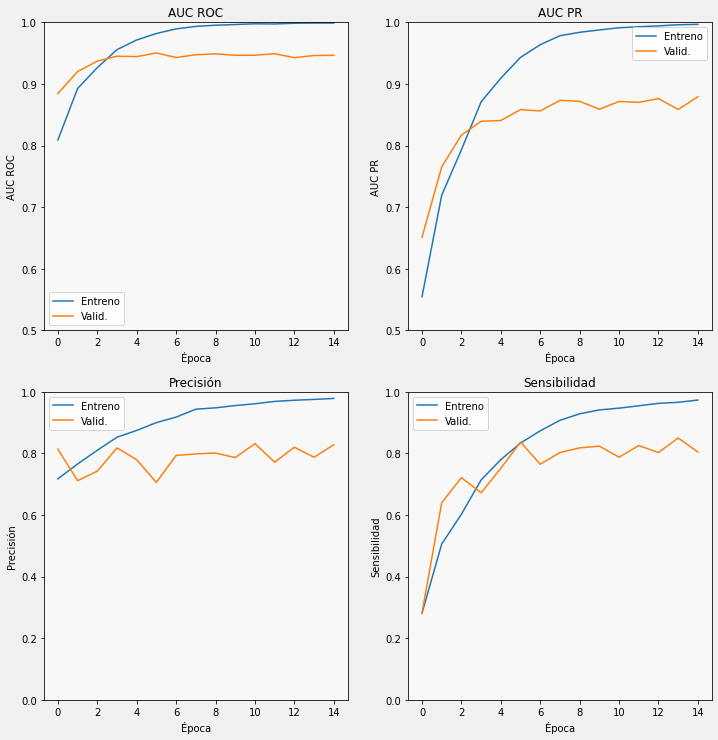

In [102]:
# Se muestran las curvas de rendimiento del modelo durante el entrenamiento
display_curves(history)

In [90]:
# Alamacena métricas
df_metrics.to_pickle(TFG_PATH+"TFG_df_metrics.pkl")

## Almacenamiento del modelo óptimo y de las predicciones del modelo en el conjunto de prueba

In [85]:
# Se guarda el mejor modelo en un locación no volátil de Google Drive
!mv {TFG_MODEL} {TFG_MODEL}.back
!mv TFG_mejor_modelo.hdf5 {TFG_MODEL}

In [86]:
# Se carga el mejor modelo
model2 = load_model(TFG_MODEL)

In [87]:
# Se realizan las predicciones del modelo sobre el conjunto de prueba
# Etiquetas con el diagnóstico real
y_true = np.array([
  target.numpy() for img, file_name, 
  target in iter(get_test_dataset(test_datasets[MODEL_RESOLUTION]).unbatch())])

# Etiquetas con la predicción del modelo
y_pred = model2.predict(get_test_dataset(test_datasets[MODEL_RESOLUTION])).flatten()

print("Número de etiquetas con diagnósticos reales: ", y_true.shape)
print("Número de etiquetas predichas:", y_pred.shape)

Exception ignored in: <function Executor.__del__ at 0x7f82b87f5160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


28/28 [==============================] - 255s 9s/step
Número de etiquetas con diagnósticos reales:  (3483,)
Número de etiquetas predichas: (3483,)


In [91]:
# Prepara un fichero CSV con el nombre del fichero de imagen, 
# diagnóstico real y predicción (probabilidades)
import csv  
!mv {TFG_PREDICCIONES} {TFG_PREDICCIONES}.back
header = ['image_name', 'target', 'prediction']
with open(TFG_PREDICCIONES, 'w', encoding='UTF8') as f:
  writer = csv.writer(f)
  # Cabecera
  writer.writerow(header)
  idx = 0
  for img, file, target in iter(get_test_dataset(test_datasets[MODEL_RESOLUTION]).unbatch()):
    writer.writerow([file.numpy().decode('ascii'), 
          target.numpy(), 
          y_pred[idx]])
    idx = idx + 1

Exception ignored in: <function Executor.__del__ at 0x7f82b87f5160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


ISIC_0053515.png Real: No melanoma  - Predicción:[0.00014942]


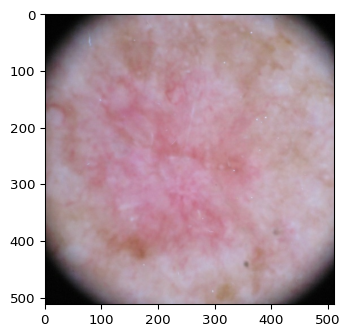

ISIC_0053456.png  Real: Melanoma  - Predicción:[0.99960405]


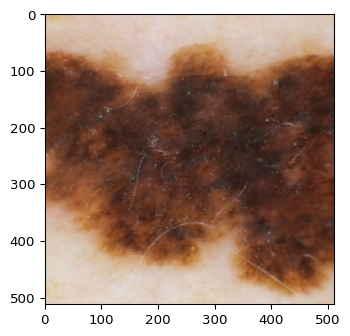

ISIC_0053493.png Real: No melanoma  - Predicción:[2.6726098e-05]


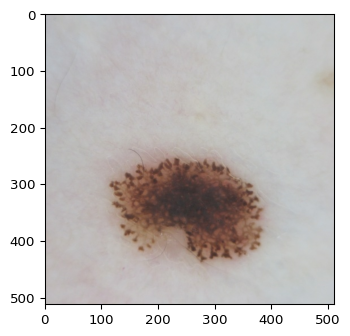

ISIC_0000199.png Real: No melanoma  - Predicción:[7.1235613e-06]


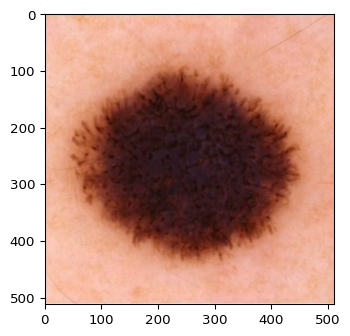

ISIC_0053483.png Real: No melanoma  - Predicción:[0.00012524]


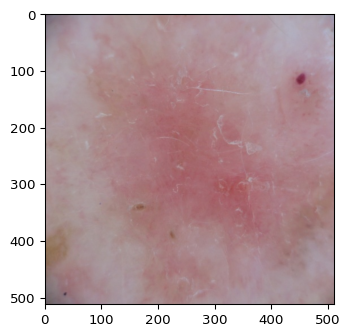

ISIC_0053534.png Real: No melanoma  - Predicción:[3.1571264e-05]


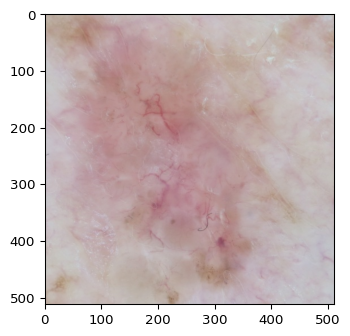

ISIC_0000072.png Real: No melanoma  - Predicción:[0.55714107]


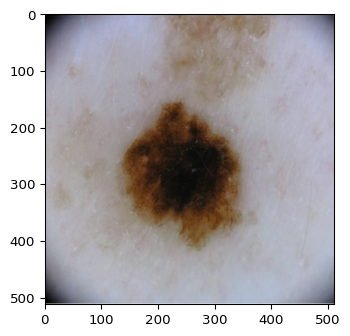

ISIC_0053615.png  Real: Melanoma  - Predicción:[0.9999765]


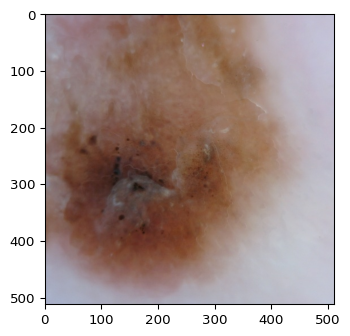

ISIC_0053555.png  Real: Melanoma  - Predicción:[0.99718946]


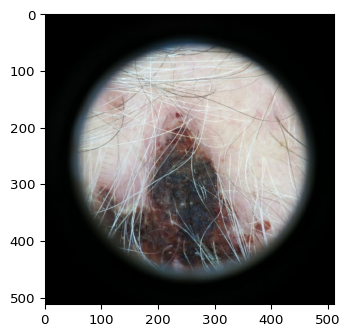

ISIC_0053618.png Real: No melanoma  - Predicción:[1.5652789e-07]


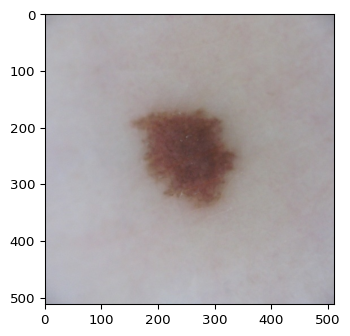

In [92]:
# Muestra 10 ejemplos de diagnósticos
limit = 0
for img, file, target in iter(get_test_dataset(test_datasets[MODEL_RESOLUTION]).unbatch()):
  plt.figure(figsize=(384/MY_DPI, 384/MY_DPI), dpi=MY_DPI)
  file_name = file.numpy().decode('ascii') + '.png'
  target_diag = " Real: Melanoma" if target.numpy() else "Real: No melanoma"
  image = img.numpy().astype(np.uint8)
  image = PIL.Image.fromarray(image)
  tensor = tf.keras.utils.img_to_array(image)
  tensor = tf.expand_dims(tensor,0)
  prediction = " - Predicción:" +  str(model2.predict(tensor, verbose=0).flatten())
  print(file_name, target_diag, prediction)
  plt.imshow(image)
  plt.show()
  limit = limit + 1
  if limit == 10: break

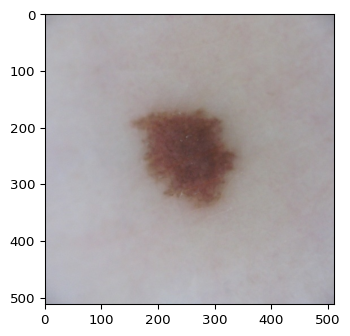

[1.5652789e-07]


In [93]:
# Ejemplo de un diagnóstico desde una imagen

# Se guarda la última imagen del apartado anterior
image.save(file_name)

# Se muestra la imagen y se realiza la predicción
plt.figure(figsize=(384/MY_DPI, 384/MY_DPI), dpi=MY_DPI)
image = PIL.Image.open(file_name)
plt.imshow(image)
plt.show()
tensor = tf.keras.utils.img_to_array(image)
tensor = tf.expand_dims(tensor,0)
prediction = model2.predict(tensor, verbose=0).flatten()
print(prediction)

In [94]:
# Se guardan 200 imágenes de prueba para la aplicación web de inferencia
# estas imágenes no han sido vistas por el modelo   

# Se borran imágenes anteriores
!rm -rf {TFG_PATH}ISIC

!mkdir {TFG_PATH}ISIC
!mkdir {TFG_PATH}ISIC/Melanoma/
!mkdir {TFG_PATH}ISIC/NoMelanoma/

limit = 0
for img, file, target in iter(get_test_dataset(test_datasets[MODEL_RESOLUTION]).unbatch()):
  file_name = file.numpy().decode('ascii') + '.jpg'
  target_diag = " Real: Melanoma" if target.numpy() else "Real: No melanoma"
  image = img.numpy().astype(np.uint8)
  image = PIL.Image.fromarray(image)
  if target.numpy():
    image.save(TFG_PATH +"ISIC/Melanoma/" + file_name)
  else:
    image.save(TFG_PATH +"ISIC/NoMelanoma/" + file_name)  
  limit = limit + 1
  if limit == 200: break

In [95]:
# Fichero comprimido con las imágenes creadas
!cp {TFG_PATH}/TFG_imagenes_leeme.txt {TFG_PATH}/ISIC 
%cd {TFG_PATH}
!tar -zcvf TFG_ISIC_images_sample_100.tar.gz ISIC

/content/drive/MyDrive/TFG
ISIC/
ISIC/Melanoma/
ISIC/Melanoma/ISIC_0053456.jpg
ISIC/Melanoma/ISIC_0053615.jpg
ISIC/Melanoma/ISIC_0053555.jpg
ISIC/Melanoma/ISIC_0053570.jpg
ISIC/Melanoma/ISIC_0000167.jpg
ISIC/Melanoma/ISIC_0053698.jpg
ISIC/Melanoma/ISIC_0000172.jpg
ISIC/Melanoma/ISIC_0053766.jpg
ISIC/Melanoma/ISIC_0000294.jpg
ISIC/Melanoma/ISIC_0053828.jpg
ISIC/Melanoma/ISIC_0053827.jpg
ISIC/Melanoma/ISIC_0000310.jpg
ISIC/Melanoma/ISIC_0053916.jpg
ISIC/Melanoma/ISIC_0000277.jpg
ISIC/Melanoma/ISIC_0000307.jpg
ISIC/Melanoma/ISIC_0054053.jpg
ISIC/Melanoma/ISIC_0054220.jpg
ISIC/Melanoma/ISIC_0000518.jpg
ISIC/Melanoma/ISIC_0054409.jpg
ISIC/Melanoma/ISIC_0054377.jpg
ISIC/Melanoma/ISIC_0009898.jpg
ISIC/Melanoma/ISIC_0009905.jpg
ISIC/Melanoma/ISIC_0054671.jpg
ISIC/Melanoma/ISIC_0009897.jpg
ISIC/Melanoma/ISIC_0010016.jpg
ISIC/Melanoma/ISIC_0054770.jpg
ISIC/Melanoma/ISIC_0010034.jpg
ISIC/Melanoma/ISIC_0010372.jpg
ISIC/Melanoma/ISIC_0054954.jpg
ISIC/Melanoma/ISIC_0055208.jpg
ISIC/Melanoma/ISIC_005

Este notebook está inspirado inspirado por:
- TFRecord Experiments - Upsample and Coarse Dropout
https://www.kaggle.com/code/cdeotte/tfrecord-experiments-upsample-and-coarse-dropout/notebook
- Splitting TensorFlow Dataset for Validation
https://www.kaggle.com/code/tt195361/splitting-tensorflow-dataset-for-validation/notebook
- Rotation Augmentation GPU/TPU - [0.96+]
https://www.kaggle.com/code/cdeotte/rotation-augmentation-gpu-tpu-0-96/notebook
- Classification on imbalanced data
https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

In [105]:
df_metrics

nombre_modelo       lr bias dropout  val_auc_roc  val_auc_pr  \
0             B0  0.00500    0       0        0.830       0.582   
1             B0  0.00100    0       0        0.892       0.751   
2             B0  0.00050    0       0        0.912       0.794   
3             B0  0.00010    0       0        0.921       0.809   
4             B0  0.00005    0       0        0.916       0.802   
5             B0  0.00050    1       0        0.908       0.796   
6             B0  0.00010    1       0        0.921       0.797   
7             B0  0.00005    1       0        0.930       0.809   
8             B0  0.00005    1     0.2        0.924       0.805   
9             B0  0.00005    1     0.3        0.924       0.796   
10            B0  0.00005    1     0.4        0.934       0.813   
11            B0  0.00005    1     0.5        0.930       0.821   
12            B1  0.00005    1     0.4        0.939       0.815   
13            B2  0.00005    1     0.4        0.926       0.814   
14            B3  0.00005    1     0.4        0.941       0.838   
15            B4  0.00005    1     0.4        0.945       0.853   
16            B5  0.00005    1     0.4        0.950       0.868   
17            B6  0.00005    1     0.4        0.954       0.879   

    val_precision  val_recall  val_F1  
0           0.413       0.716   0.524  
1           0.728       0.708   0.718  
2           0.707       0.718   0.712  
3           0.767       0.693   0.728  
4           0.778       0.652   0.709  
5           0.795       0.718   0.755  
6           0.742       0.742   0.742  
7           0.710       0.731   0.720  
8           0.820       0.636   0.716  
9           0.767       0.659   0.709  
10          0.682       0.754   0.716  
11          0.837       0.631   0.720  
12          0.760       0.744   0.752  
13          0.753       0.735   0.744  
14          0.721       0.824   0.769  
15          0.797       0.788   0.792  
16          0.822       0.820   0.821  
17          0.773       0.833   0.802